<a href="https://colab.research.google.com/github/rapu34/A1_performance_factory_Aveners/blob/main/%ED%8F%89%EA%B0%80%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import gc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 27 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 3s (3,590 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

In [ ]:
bidding = pd.read_csv("/content/drive/MyDrive/A1project/bidding_result.csv", encoding='UTF8')

In [ ]:
indexs = list(set(bidding['index'].to_list()))
print(len(indexs))

48896


In [ ]:
idx_distinct_df = bidding.drop_duplicates(['index'])
idx_distinct_df

,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4,date
0,3575092,3,0,0.0,3.000000,50,165900,165900,0,가구/인테리어,침실가구,장롱/붙박이장,드레스룸,20221031
1,3575637,6,0,0.0,3.333333,50,10900,10900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저,20221031
2,4129259,7,0,0.0,8.000000,50,255000,255000,-1,가구/인테리어,거실가구,소파,패브릭소파,20221031
3,4131479,36,3,150.0,4.416667,140,190000,190000,20000,가구/인테리어,아동/주니어가구,책상의자세트,NaN,20221031
4,4131482,224,0,0.0,5.696429,50,129000,129000,0,가구/인테리어,아동/주니어가구,책상,NaN,20221031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1337083,2566795,5,0,0.0,13.200000,500,19900,19900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저,20230103
1337084,2566880,3,0,0.0,17.000000,500,23900,23900,3000,생활/건강,문구/사무용품,이벤트/파티용품,데코용품,20230103
1337085,2566881,1,0,0.0,8.000000,500,2500,2500,3000,가구/인테리어,인테리어소품,기타장식용품,NaN,20230103
1337086,2566891,2,0,0.0,4.000000,500,21000,21000,3000,생활/건강,정원/원예용품,화분받침,NaN,20230103


In [ ]:
bidding['Sum of AD rank'] = bidding['Sum of AD rank'].round(0)
bidding['Sum of AD rank'] # rank 살리자 -가설: 특정 rank 구간에 click 까지만 유의미한 결과가 나타났다. 
#확인 2-4등일때 click 이 가장 많음
# 여성 상품의 경우 유의미한 순위 확인

0           3.0
1           3.0
2           8.0
3           4.0
4           6.0
           ... 
1337083    13.0
1337084    17.0
1337085     8.0
1337086     4.0
1337087    12.0
Name: Sum of AD rank, Length: 1337088, dtype: float64

In [ ]:
# 날짜 데이터 테이트타임으로 바꾸기
def _trans_date_time(bidding):
    bidding.index = pd.to_datetime(bidding['date'], format='%Y%m%d')
    bidding.drop('date', axis=1, inplace=True)
    return bidding

In [ ]:
_trans_date_time(bidding)


,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4
date,,,,,,,,,,,,,
2022-10-31,3575092,3,0,0.0,3.0,50,165900,165900,0,가구/인테리어,침실가구,장롱/붙박이장,드레스룸
2022-10-31,3575637,6,0,0.0,3.0,50,10900,10900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저
2022-10-31,4129259,7,0,0.0,8.0,50,255000,255000,-1,가구/인테리어,거실가구,소파,패브릭소파
2022-10-31,4131479,36,3,150.0,4.0,140,190000,190000,20000,가구/인테리어,아동/주니어가구,책상의자세트,NaN
2022-10-31,4131482,224,0,0.0,6.0,50,129000,129000,0,가구/인테리어,아동/주니어가구,책상,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-03,2566795,5,0,0.0,13.0,500,19900,19900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저
2023-01-03,2566880,3,0,0.0,17.0,500,23900,23900,3000,생활/건강,문구/사무용품,이벤트/파티용품,데코용품
2023-01-03,2566881,1,0,0.0,8.0,500,2500,2500,3000,가구/인테리어,인테리어소품,기타장식용품,NaN


In [ ]:
# CTR = 클릭률
# CPC = 클릭당 비용
# CPM = 1000회 노출당 비용
bidding["CTR"] = (bidding["Click"]/bidding["Impression"]) * 100
bidding["CPC"] = (bidding["Cost"]/bidding["Click"])
bidding["CPM"] = (bidding["Cost"]/1000)

In [ ]:
# null값 퍼센트로 보기
(bidding.isnull().sum()/ bidding.shape[0]).sort_values(ascending=False)

CPC                0.753309
Category Name 4    0.304360
Category Name 3    0.004388
Sum of AD rank     0.000007
index              0.000000
Impression         0.000000
Click              0.000000
Cost               0.000000
Bid                0.000000
Price(PC)          0.000000
Price(Mobile)      0.000000
Delivery Fee       0.000000
Category Name 1    0.000000
Category Name 2    0.000000
CTR                0.000000
CPM                0.000000
dtype: float64

In [ ]:
"""
Category Name 3, Sum of AD rank 는 결측치 자료가 적어서 drop한다
CPC의 결측치는 우선 0 으로 처리하고 다른 EDA를 해본다

"""

bidding2 = bidding.copy()
bidding2['Category Name 4'].fillna('uncategory', inplace = True)
bidding2['CPC'].fillna(0, inplace = True)
bidding2.dropna(axis = 0, inplace = True)
print(bidding2.isnull().sum().sort_values(ascending=False)) # null값 퍼센트로 표현
bidding2

index              0
Impression         0
Click              0
Cost               0
Sum of AD rank     0
Bid                0
Price(PC)          0
Price(Mobile)      0
Delivery Fee       0
Category Name 1    0
Category Name 2    0
Category Name 3    0
Category Name 4    0
CTR                0
CPC                0
CPM                0
dtype: int64


,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4,CTR,CPC,CPM
date,,,,,,,,,,,,,,,,
2022-10-31,3575092,3,0,0.0,3.0,50,165900,165900,0,가구/인테리어,침실가구,장롱/붙박이장,드레스룸,0.000000,0.0,0.00
2022-10-31,3575637,6,0,0.0,3.0,50,10900,10900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저,0.000000,0.0,0.00
2022-10-31,4129259,7,0,0.0,8.0,50,255000,255000,-1,가구/인테리어,거실가구,소파,패브릭소파,0.000000,0.0,0.00
2022-10-31,4131479,36,3,150.0,4.0,140,190000,190000,20000,가구/인테리어,아동/주니어가구,책상의자세트,uncategory,8.333333,50.0,0.15
2022-10-31,4131482,224,0,0.0,6.0,50,129000,129000,0,가구/인테리어,아동/주니어가구,책상,uncategory,0.000000,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-03,2566795,5,0,0.0,13.0,500,19900,19900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저,0.000000,0.0,0.00
2023-01-03,2566880,3,0,0.0,17.0,500,23900,23900,3000,생활/건강,문구/사무용품,이벤트/파티용품,데코용품,0.000000,0.0,0.00
2023-01-03,2566881,1,0,0.0,8.0,500,2500,2500,3000,가구/인테리어,인테리어소품,기타장식용품,uncategory,0.000000,0.0,0.00


In [ ]:
bidding3 = bidding2.drop_duplicates(['index'])
bidding3

,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4,CTR,CPC,CPM
date,,,,,,,,,,,,,,,,
2022-10-31,3575092,3,0,0.0,3.0,50,165900,165900,0,가구/인테리어,침실가구,장롱/붙박이장,드레스룸,0.000000,0.0,0.00
2022-10-31,3575637,6,0,0.0,3.0,50,10900,10900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저,0.000000,0.0,0.00
2022-10-31,4129259,7,0,0.0,8.0,50,255000,255000,-1,가구/인테리어,거실가구,소파,패브릭소파,0.000000,0.0,0.00
2022-10-31,4131479,36,3,150.0,4.0,140,190000,190000,20000,가구/인테리어,아동/주니어가구,책상의자세트,uncategory,8.333333,50.0,0.15
2022-10-31,4131482,224,0,0.0,6.0,50,129000,129000,0,가구/인테리어,아동/주니어가구,책상,uncategory,0.000000,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-03,2566795,5,0,0.0,13.0,500,19900,19900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저,0.000000,0.0,0.00
2023-01-03,2566880,3,0,0.0,17.0,500,23900,23900,3000,생활/건강,문구/사무용품,이벤트/파티용품,데코용품,0.000000,0.0,0.00
2023-01-03,2566881,1,0,0.0,8.0,500,2500,2500,3000,가구/인테리어,인테리어소품,기타장식용품,uncategory,0.000000,0.0,0.00


In [ ]:
bidding_rank = bidding2.sort_values(by = 'Sum of AD rank', ignore_index=True, ascending=True)
bidding_rank

,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4,CTR,CPC,CPM
0,9190721,22,1,280.0,1.0,60,9900,9900,3000,패션잡화,여성신발,실내화,uncategory,4.545455,280.0,0.28
1,3592074,1,0,0.0,1.0,300,9900,9900,3000,화장품/미용,헤어케어,린스,uncategory,0.000000,0.0,0.00
2,3592078,3,0,0.0,1.0,50,5900,5900,3000,화장품/미용,헤어케어,헤어에센스,uncategory,0.000000,0.0,0.00
3,3044310,39,0,0.0,1.0,50,1187500,1187500,-1,가구/인테리어,주방가구,식탁/의자,식탁테이블,0.000000,0.0,0.00
4,3044301,1,0,0.0,1.0,50,799000,799000,0,가구/인테리어,주방가구,식탁/의자,식탁테이블,0.000000,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1331206,3303386,1,0,0.0,100.0,360,39900,39900,-1,가구/인테리어,침실가구,협탁,uncategory,0.000000,0.0,0.00
1331207,112516,1,0,0.0,100.0,50,97900,97900,0,가구/인테리어,침실가구,화장대,콘솔,0.000000,0.0,0.00
1331208,9190741,1,0,0.0,100.0,300,15840,15840,3000,패션잡화,남성신발,슬리퍼,uncategory,0.000000,0.0,0.00
1331209,9143558,2,0,0.0,100.0,50,22900,22900,4000,가구/인테리어,서재/사무용가구,의자,스툴,0.000000,0.0,0.00


In [ ]:
cate_name = bidding_rank['Category Name 1'].unique()
cate_name

group_df = {}
for cate in cate_name:
    group_df[cate] = bidding_rank[bidding_rank['Category Name 1'] == cate]

def barplot_df(bidding_rank, name):
    plt.figure(figsize=(24, 12))
    sns.barplot(x='Sum of AD rank', y='Click', data=bidding_rank)
    plt.title(f"Sum of AD rank of {name}", fontsize=20)
    plt.xlabel("Sum of AD rank", fontsize=15)
    plt.ylabel("Click", fontsize=15)
    plt.show()


In [ ]:
plt.rcParams['font.family'] = 'NanumGothic'


/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54056 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49496 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51105 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54868 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 54056 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49496 missing from current font.
  font.set_te

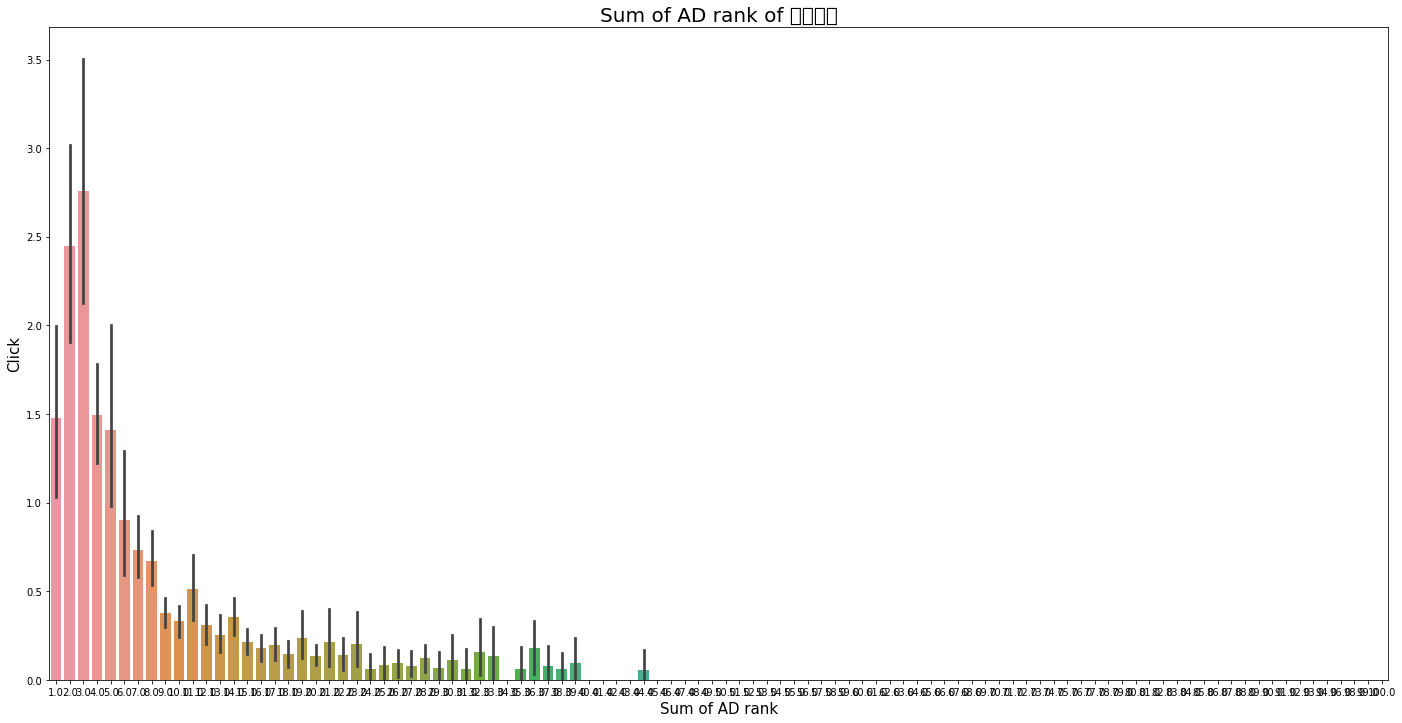

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54868 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51109 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54408 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48120 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50857 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 54868 missing from current font.
  font.set_

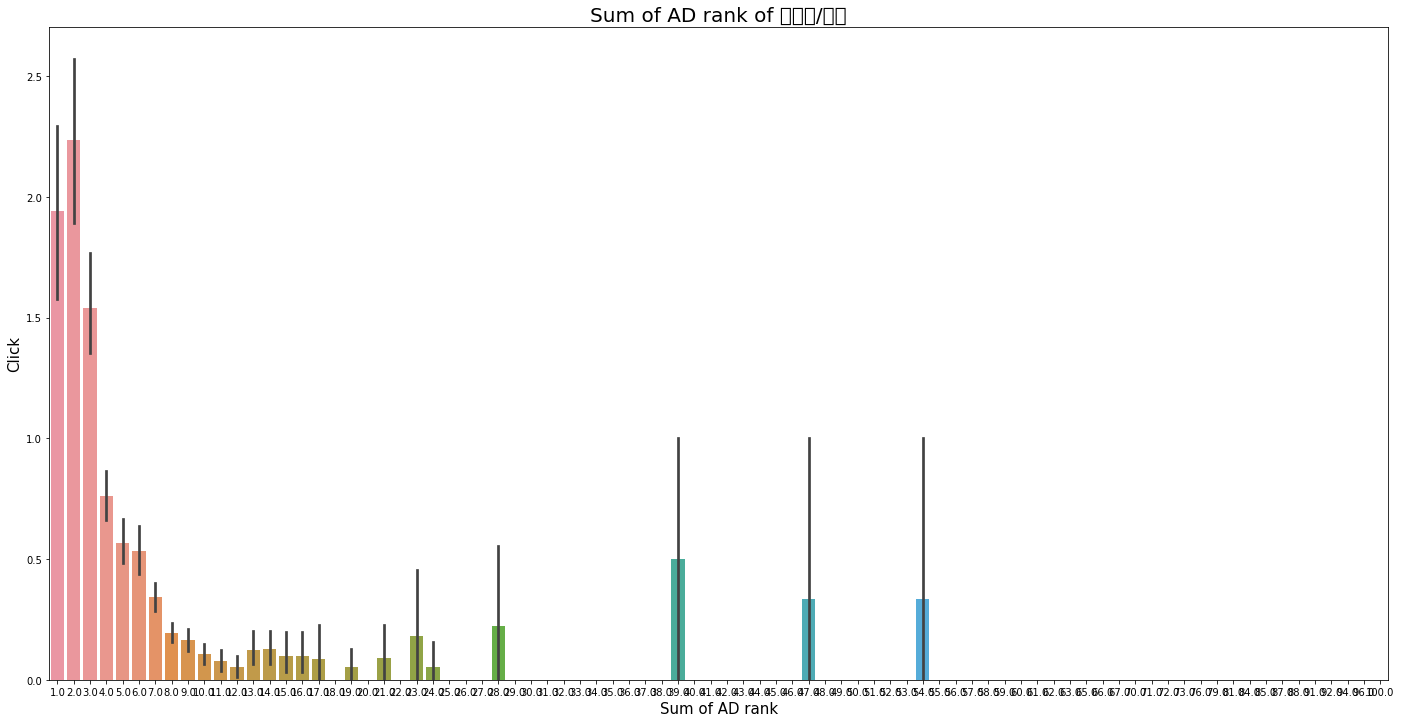

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44396 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51064 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53580 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47532 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50612 missing from current font.
  font.set_

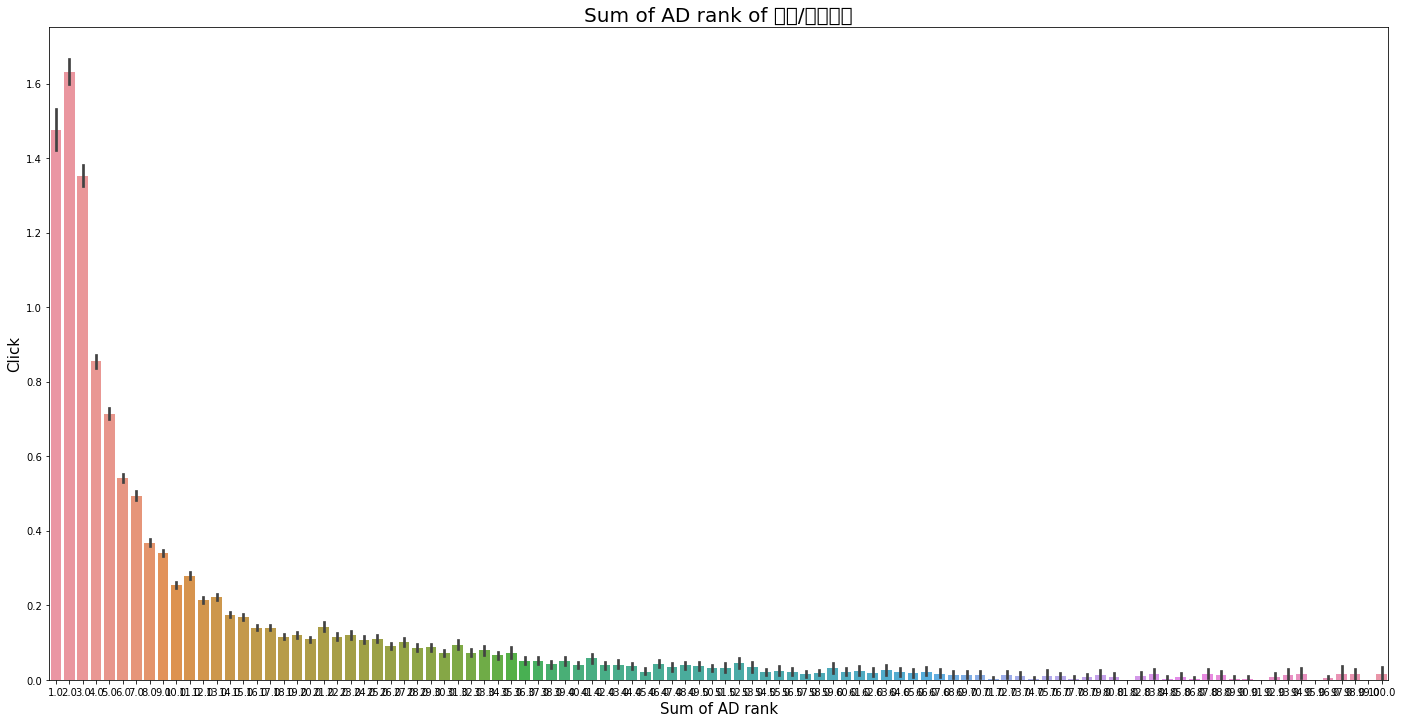

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54876 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44148 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44053 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49373 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 54876 missing from current font.
  font.set_te

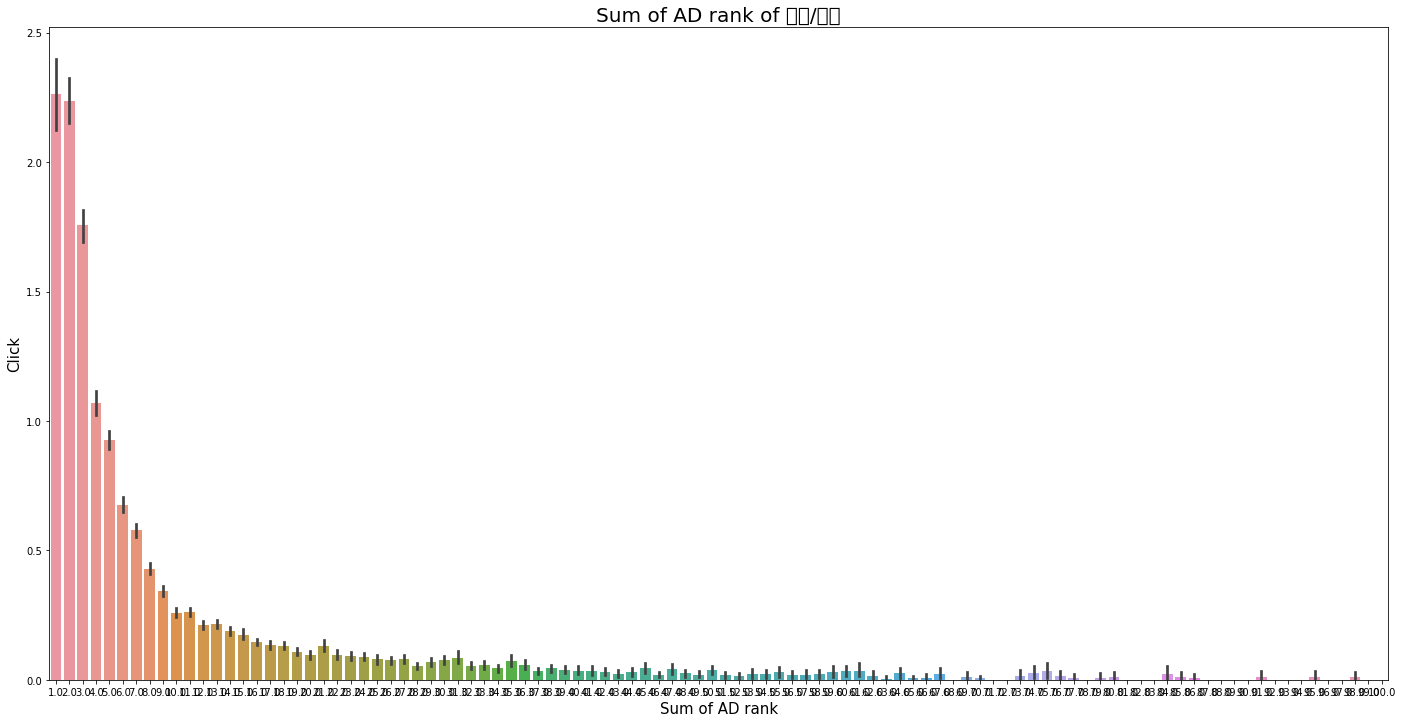

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52636 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49328 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50977 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50500 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 52636 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49328 missing from current font.
  font.set_te

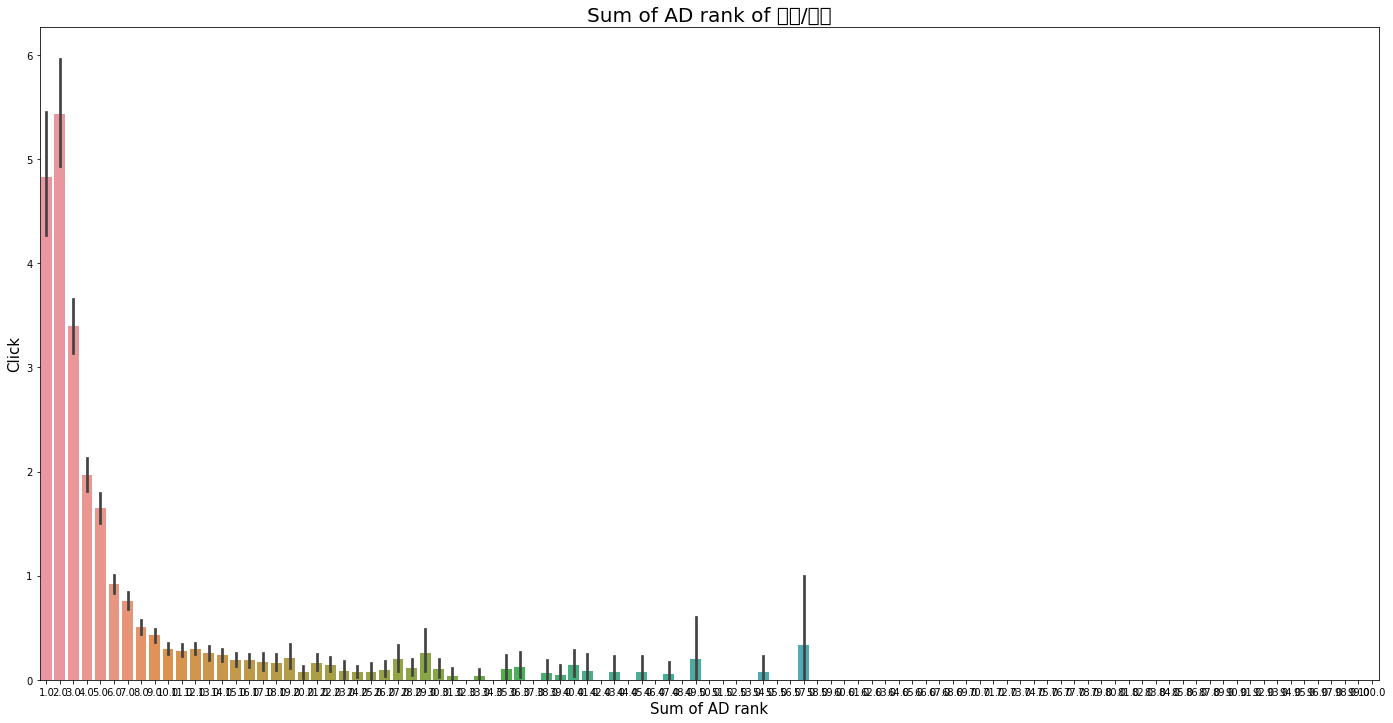

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50668 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54876 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54200 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_

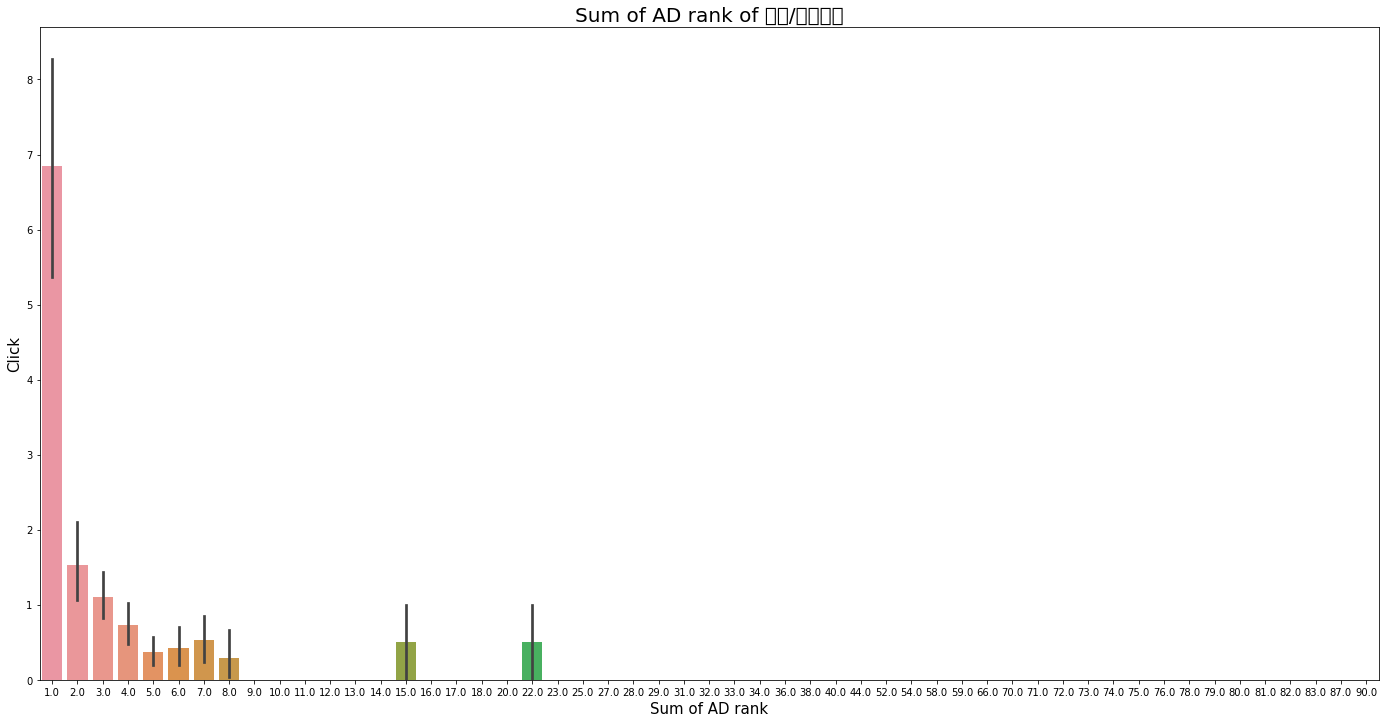

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46356 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51648 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53560 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 46356 missing from current font.
  font.set_

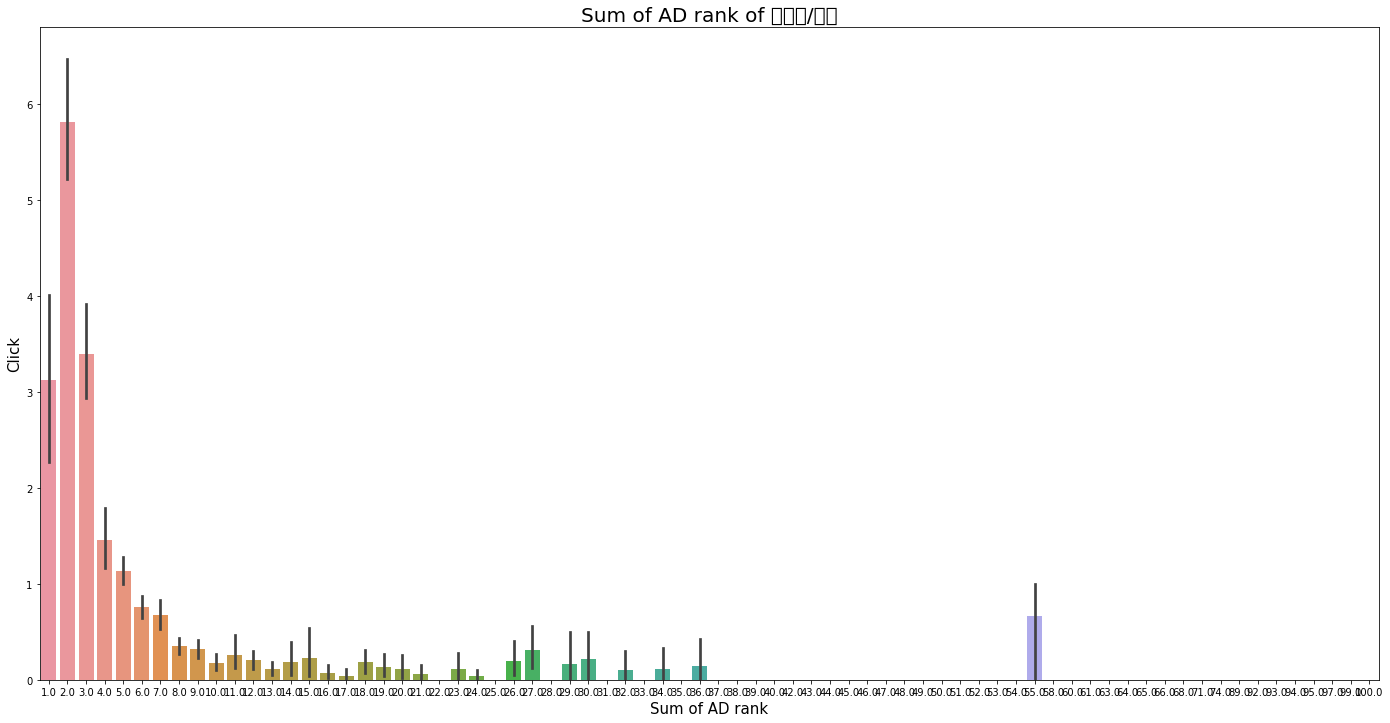

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54252 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52768 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47112 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51200 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_

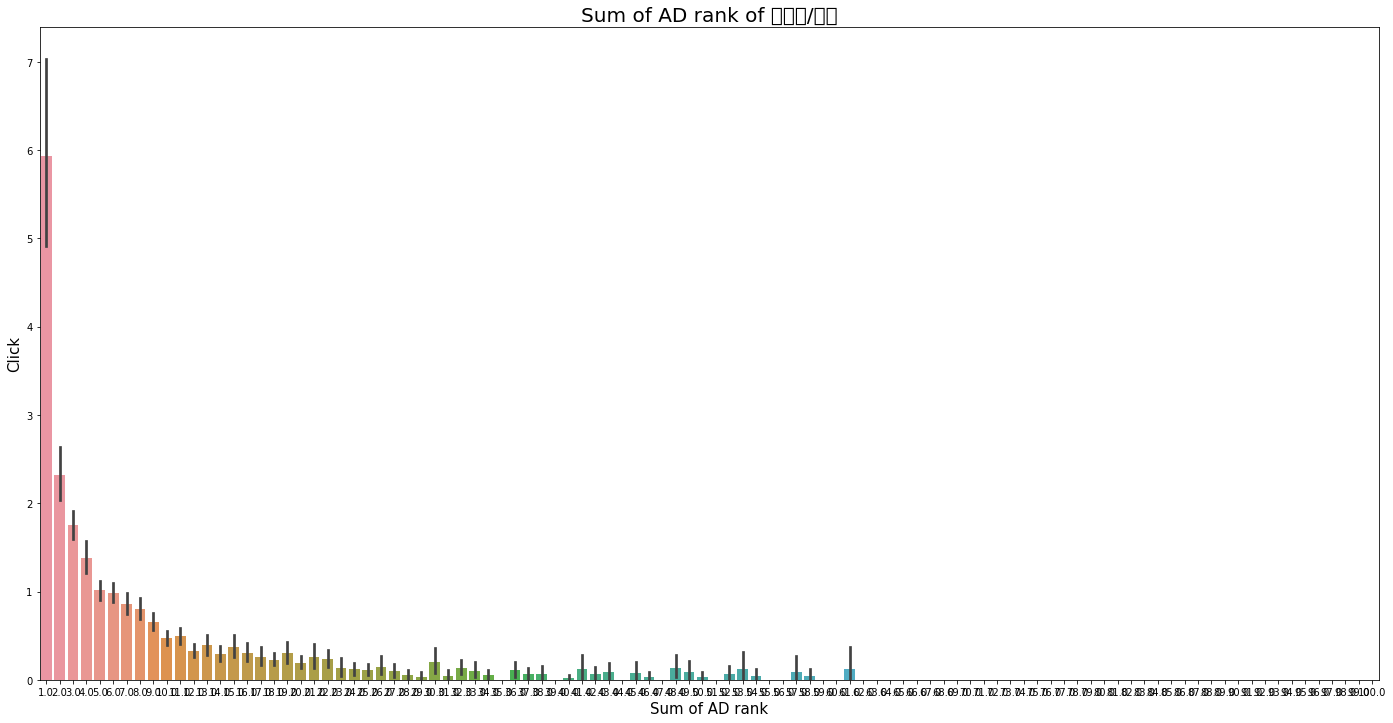

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54056 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49496 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47448 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 54056 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49496 missing from current font.
  font.set_te

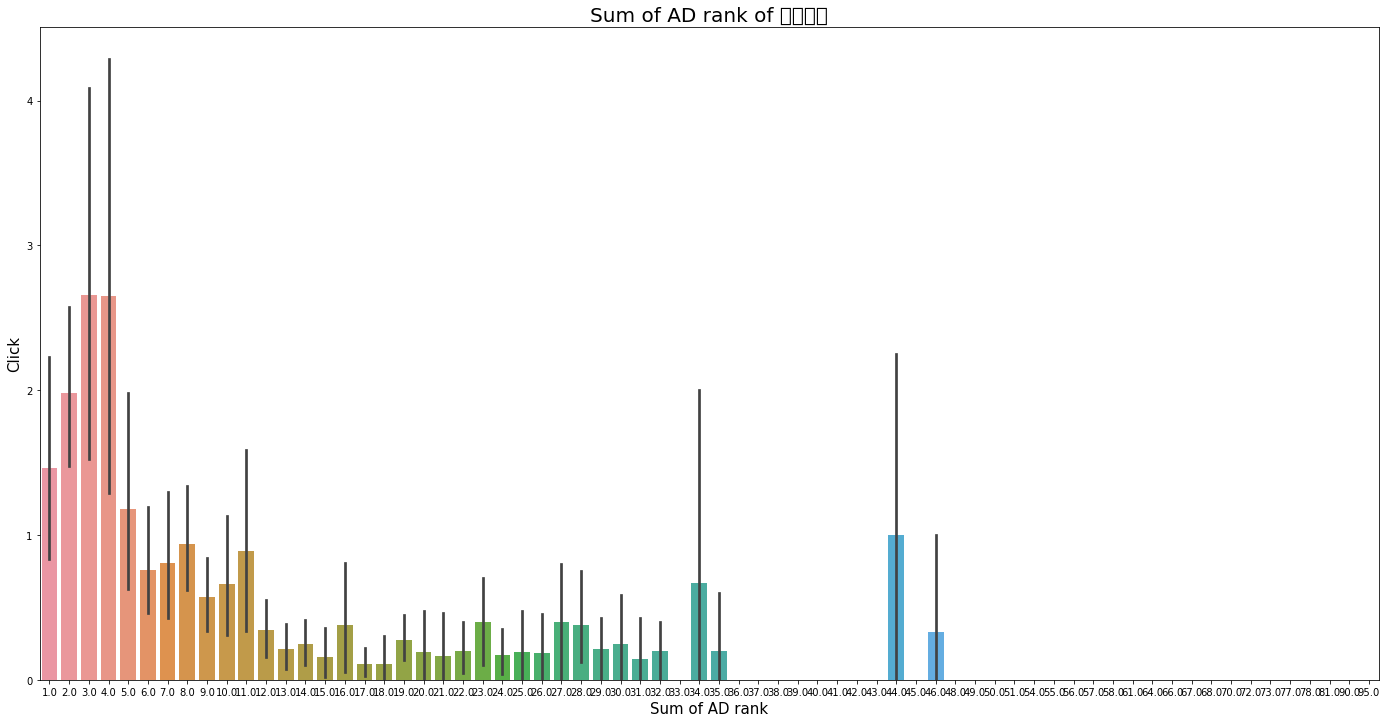

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49885 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54408 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49885 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 54408 missing from current font.
  font.set_text(s, 0, flags=flags)


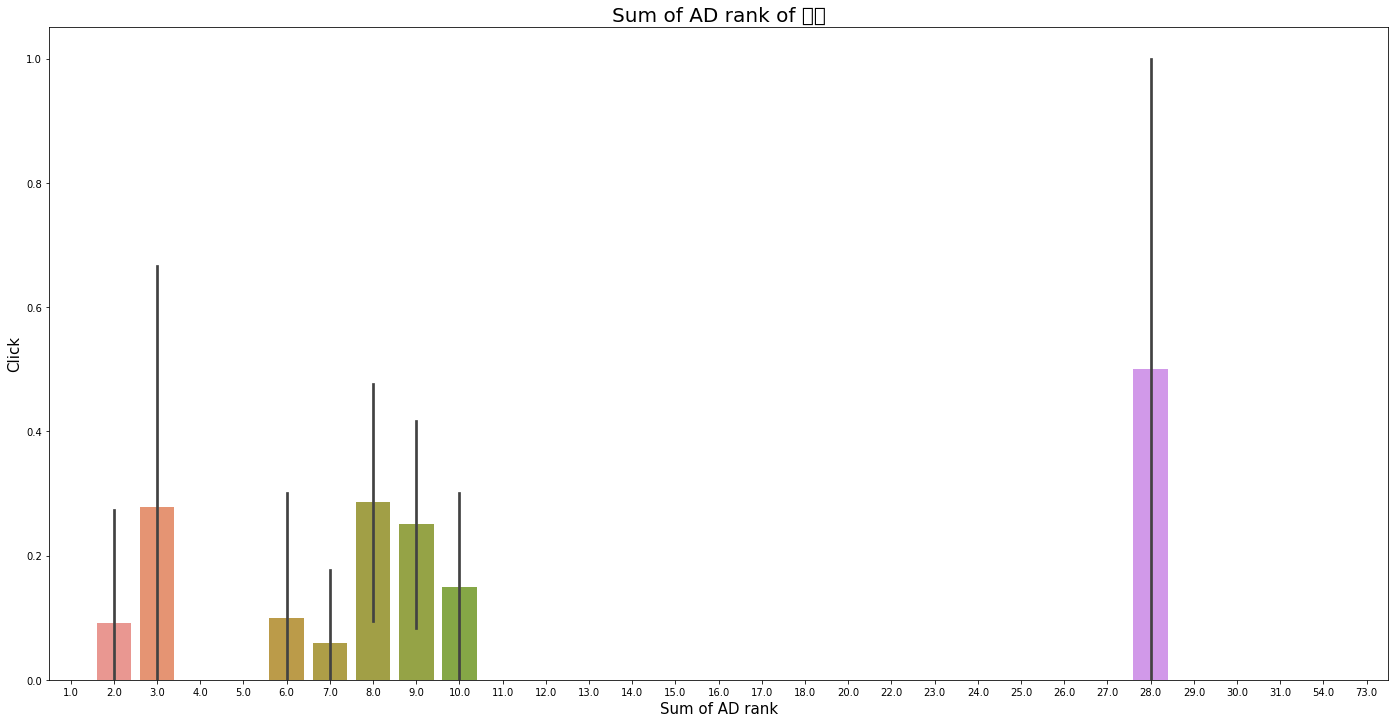

In [ ]:
for key, df in group_df.items():
    barplot_df(df, name=key)

### 평가모델 NDCG 사용

In [ ]:
import numpy as np

def NDCG(y_true, y_pred):
    # y_true: ground truth, y_pred: predicted values
    # sort y_pred in descending order
    y_pred = np.flip(np.argsort(y_pred), axis=0)
    
    dcg = 0
    for i in range(len(y_pred)):
        # 각 광고의 클릭 횟수
        click = y_true[y_pred[i]]
        dcg += (2 ** click - 1) / np.log2(i + 2)
        
    idcg = 0
    y_true = np.sort(y_true)[::-1]
    print("완료1")

    for i in range(len(y_true)):
        idcg += (2 ** y_true[i] - 1) / np.log2(i + 2)
    print("완료2")
        
    return dcg / idcg

In [ ]:
NDCG(bidding_rank['Click'], bidding_rank['Sum of AD rank'])

<ipython-input-30-d9db56523979>:12: RuntimeWarning: overflow encountered in long_scalars
  dcg += (2 ** click - 1) / np.log2(i + 2)


완료1


<ipython-input-30-d9db56523979>:19: RuntimeWarning: overflow encountered in long_scalars
  idcg += (2 ** y_true[i] - 1) / np.log2(i + 2)


완료2


0.5395977622048891

In [ ]:
NDCG(bidding_rank['Click'], bidding_rank['Cost'])

<ipython-input-30-d9db56523979>:12: RuntimeWarning: overflow encountered in long_scalars
  dcg += (2 ** click - 1) / np.log2(i + 2)
<ipython-input-30-d9db56523979>:19: RuntimeWarning: overflow encountered in long_scalars
  idcg += (2 ** y_true[i] - 1) / np.log2(i + 2)


완료1
완료2


0.4497968211905429

In [ ]:
NDCG(bidding_rank['Sum of AD rank'], bidding_rank['Cost'])

0.40515892419214694

In [ ]:
bidding_rank[bidding_rank['Category Name 1'] == '화장품/미용']['Click']

1          0
2          0
305        0
404        1
410        1
          ..
1329110    0
1329252    0
1329927    0
1330961    0
1331113    0
Name: Click, Length: 7471, dtype: int64

In [ ]:
NDCG(bidding_rank[bidding_rank['Category Name 1'] == '화장품/미용']['Click'], bidding_rank[bidding_rank['Category Name 1'] == '화장품/미용']['Sum of AD rank'])

KeyError: ignored

In [ ]:
bidding_rank

,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4,CTR,CPC,CPM
0,9190721,22,1,280.0,1.0,60,9900,9900,3000,패션잡화,여성신발,실내화,uncategory,4.545455,280.0,0.28
1,3592074,1,0,0.0,1.0,300,9900,9900,3000,화장품/미용,헤어케어,린스,uncategory,0.000000,0.0,0.00
2,3592078,3,0,0.0,1.0,50,5900,5900,3000,화장품/미용,헤어케어,헤어에센스,uncategory,0.000000,0.0,0.00
3,3044310,39,0,0.0,1.0,50,1187500,1187500,-1,가구/인테리어,주방가구,식탁/의자,식탁테이블,0.000000,0.0,0.00
4,3044301,1,0,0.0,1.0,50,799000,799000,0,가구/인테리어,주방가구,식탁/의자,식탁테이블,0.000000,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1331206,3303386,1,0,0.0,100.0,360,39900,39900,-1,가구/인테리어,침실가구,협탁,uncategory,0.000000,0.0,0.00
1331207,112516,1,0,0.0,100.0,50,97900,97900,0,가구/인테리어,침실가구,화장대,콘솔,0.000000,0.0,0.00
1331208,9190741,1,0,0.0,100.0,300,15840,15840,3000,패션잡화,남성신발,슬리퍼,uncategory,0.000000,0.0,0.00
1331209,9143558,2,0,0.0,100.0,50,22900,22900,4000,가구/인테리어,서재/사무용가구,의자,스툴,0.000000,0.0,0.00


In [ ]:
#화장품
cosmetic = bidding_rank[(bidding_rank['Category Name 1'] == '화장품/미용')]
cosmetic

,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4,CTR,CPC,CPM
1,3592074,1,0,0.0,1.0,300,9900,9900,3000,화장품/미용,헤어케어,린스,uncategory,0.000000,0.0,0.00
2,3592078,3,0,0.0,1.0,50,5900,5900,3000,화장품/미용,헤어케어,헤어에센스,uncategory,0.000000,0.0,0.00
305,1496633,1,0,0.0,1.0,250,416500,416500,4000,화장품/미용,베이스메이크업,메이크업베이스,uncategory,0.000000,0.0,0.00
404,3592077,39,1,310.0,1.0,50,14900,14900,3000,화장품/미용,헤어케어,트리트먼트,uncategory,2.564103,310.0,0.31
410,9849669,3,1,50.0,1.0,50,11000,11000,3000,화장품/미용,스킨케어,에센스,uncategory,33.333333,50.0,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1329110,3592067,1,0,0.0,94.0,50,14900,14900,3000,화장품/미용,헤어케어,샴푸,uncategory,0.000000,0.0,0.00
1329252,3592066,1,0,0.0,94.0,250,8900,8900,3000,화장품/미용,헤어케어,헤어에센스,uncategory,0.000000,0.0,0.00
1329927,7274773,1,0,0.0,96.0,350,4200,4200,3000,화장품/미용,바디케어,핸드케어,uncategory,0.000000,0.0,0.00
1330961,5165763,1,0,0.0,100.0,250,18800,18800,0,화장품/미용,뷰티소품,헤어소품,헤어브러시,0.000000,0.0,0.00


In [ ]:
NDCG(cosmetic['Click'], cosmetic['Sum of AD rank'])

KeyError: ignored

###MAP


In [ ]:
def mean_average_precision(relevance, rank):
    score = 0
    num_hits = 0
    for i, rel in enumerate(relevance):
        if rel > 0:
            num_hits += 1
            score += num_hits / (i+1)
    return score / num_hits if num_hits != 0 else 0

In [ ]:
mean_average_precision(bidding_rank['Click'], bidding_rank['Sum of AD rank'])

0.37058552080196194

In [ ]:
mean_average_precision(cosmetic['Click'], cosmetic['Sum of AD rank'])

0.4467674973735433